# Random Forest

# Model 1
<h7> Using the data columns that produced the best outcome in logistic regression

In [65]:
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier

In [66]:
# Read in the csv file
titanic_df = pd.read_csv(Path("data_files/titanic_cleaned.csv"))
titanic_df.head() # Reviewing dataframe

,passenger_id,survived,name,sex,sibsp,parch,age_updated,embarked_updated,fare_updated,deck,pclass_updated
0,1,1,"Allen, Miss. Elisabeth Walton",female,0,0,29.0000,Southampton (UK),211.3375,B,First class
1,2,1,"Allison, Master. Hudson Trevor",male,1,2,0.9167,Southampton (UK),151.5500,C,First class
2,3,0,"Allison, Miss. Helen Loraine",female,1,2,2.0000,Southampton (UK),151.5500,C,First class
3,4,0,"Allison, Mr. Hudson Joshua Creighton",male,1,2,30.0000,Southampton (UK),151.5500,C,First class
4,5,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,1,2,25.0000,Southampton (UK),151.5500,C,First class


### Preparing the data

In [67]:
# Create a copy of the dataframe
titanic_rf_one = titanic_df.copy()

<h7> Extracting tile from name

In [68]:
# Extracting titles from passenger name and assigning them to a new column
name_split = titanic_rf_one['name'].str.split(',', expand=True)[1] # splitting name in two based on the ',' and taking the second column which contains the title
title = name_split.str.split('.', expand=True)[0] # splitting name in two based on the full stop and taking the first column that contains only the title
title = title.str.strip() # removing the additional space at the start of the title
titanic_rf_one['title'] = title # adding title as a new column in the data frame

In [69]:
# Creating a function to classify the titles into different groups
def title_grouped(title):
        if title == 'Miss' or title == 'Mlle' or title == 'Ms':
            return "Miss"
        elif title == 'Mrs' or title =='Mme':
            return "Mrs"
        elif title == "Mr" or title == 'Dr' or title == 'Rev':
            return "Mr"
        elif title == "Master":
            return "male_child"
        elif title == "Col" or title == "Major" or title == "Capt":
            return "Military"
        elif title == "Don" or title == "Jonkheer" or title == "Sir":
            return "Noblility"
        elif title == "the Countess" or title == "Lady" or title == "Dona":
            return "Noblility"
        else:
            return title

In [70]:
# Calling that function and assigning results to new column in dataframe
titanic_rf_one['title_grouped'] = titanic_rf_one['title'].apply(title_grouped)
titanic_rf_one.drop(['title', 'name'], axis=1, inplace=True) # dropping the title and name columns as not required
titanic_rf_one.head()

,passenger_id,survived,sex,sibsp,parch,age_updated,embarked_updated,fare_updated,deck,pclass_updated,title_grouped
0,1,1,female,0,0,29.0000,Southampton (UK),211.3375,B,First class,Miss
1,2,1,male,1,2,0.9167,Southampton (UK),151.5500,C,First class,male_child
2,3,0,female,1,2,2.0000,Southampton (UK),151.5500,C,First class,Miss
3,4,0,male,1,2,30.0000,Southampton (UK),151.5500,C,First class,Mr
4,5,0,female,1,2,25.0000,Southampton (UK),151.5500,C,First class,Mrs


In [71]:
titanic_rf_one['title_grouped'].value_counts(dropna=False)

Mr            773
Miss          264
Mrs           198
male_child     61
Military        7
Noblility       6
Name: title_grouped, dtype: int64

<h7> Counting the number of family members travelling with them and assigning it to a new value

In [72]:
# Summing the number of family members
titanic_rf_one['family_members'] = titanic_rf_one['sibsp'] + titanic_rf_one['parch']

# Dropping sibsp and parch columns as they are included in the new column as well as passenger_id
titanic_rf_one = titanic_rf_one.drop(['sibsp', 'parch', 'passenger_id'], axis=1) 
titanic_rf_one.head()

,survived,sex,age_updated,embarked_updated,fare_updated,deck,pclass_updated,title_grouped,family_members
0,1,female,29.0000,Southampton (UK),211.3375,B,First class,Miss,0
1,1,male,0.9167,Southampton (UK),151.5500,C,First class,male_child,3
2,0,female,2.0000,Southampton (UK),151.5500,C,First class,Miss,3
3,0,male,30.0000,Southampton (UK),151.5500,C,First class,Mr,3
4,0,female,25.0000,Southampton (UK),151.5500,C,First class,Mrs,3


<h7> Convert categorical data

In [73]:
# converting categorical using get_dummies and dropping the first column so the importance isn't inflated
sex_dummies = pd.get_dummies(titanic_rf_one['sex'], drop_first=True) 
embarked_dummies = pd.get_dummies(titanic_rf_one['embarked_updated'], drop_first=True)
deck_dummies = pd.get_dummies(titanic_rf_one['deck'], drop_first=True)
pclass_dummies = pd.get_dummies(titanic_rf_one['pclass_updated'], drop_first=True)
title_dummies = pd.get_dummies(titanic_rf_one['title_grouped'], drop_first=True)

# Concatenate the encoded dummies with the data frame and drop uncessary columns
df_titanic_transformed = pd.concat([titanic_rf_one, sex_dummies, embarked_dummies, deck_dummies, pclass_dummies, title_dummies], axis=1)

# dropping columns not required
df_titanic_transformed = df_titanic_transformed.drop(['sex', 'embarked_updated', 'deck', 'pclass_updated', 'title_grouped'], axis=1) 

df_titanic_transformed.head()

,survived,age_updated,fare_updated,family_members,male,Queenstown (IE),Southampton (UK),B,C,D,...,G,T,Unknown,Second class,Third class,Miss,Mr,Mrs,Noblility,male_child
0,1,29.0000,211.3375,0,0,0,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1,0.9167,151.5500,3,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,2.0000,151.5500,3,0,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,0,30.0000,151.5500,3,1,0,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,0,25.0000,151.5500,3,0,0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0


<h7> Separate the data into labels and features

In [74]:
# Separate the features (X) from the target (y)
# Define features set
X = df_titanic_transformed.copy()
X.drop("survived", axis=1, inplace=True)
X.head()

,age_updated,fare_updated,family_members,male,Queenstown (IE),Southampton (UK),B,C,D,E,...,G,T,Unknown,Second class,Third class,Miss,Mr,Mrs,Noblility,male_child
0,29.0000,211.3375,0,0,0,1,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0.9167,151.5500,3,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2.0000,151.5500,3,0,0,1,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,30.0000,151.5500,3,1,0,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,25.0000,151.5500,3,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [75]:
# Define target vector
y= df_titanic_transformed["survived"].ravel()
y[:5]

array([1, 1, 0, 0, 0], dtype=int64)

<h7> Split data into training and testing datasets using train_test_split

In [76]:
# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1, 
                                                    stratify=y)
X_train.shape


(981, 21)

## Apply random over sampler due to the imblanced data

In [77]:
# # Instantiate the random oversample model
# ros = RandomOverSampler(random_state=1)

# # Fit the original training data to the random_oversampler model
# X_train_ros, y_train_ros= ros.fit_resample(X_train, y_train)


### Fitting the Random Forest Model

In [78]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

In [79]:
# Fitting the model
rf_model = rf_model.fit(X_train, y_train)

In [80]:
# Make predictions
predictions = rf_model.predict(X_test)

### Evaluate the models performance

In [81]:
# Confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=['Actual - Did not survive', 'Actual - Survived'], columns=['Predicted - perished', 'Predicted - survived']
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [82]:
# Displaying results
print(f"The balanced accuracy score of the model is {balanced_accuracy_score(y_test, predictions)}")
print(f"The accuracy score of the model is : {acc_score}")
print(f"")
print("Confusion Matrix")
display(cm_df)
print("Classification Report")
print(classification_report(y_test, predictions))

The balanced accuracy score of the model is 0.7873497536945813
The accuracy score of the model is : 0.8109756097560976

Confusion Matrix


,Predicted - perished,Predicted - survived
Actual - Did not survive,180,23
Actual - Survived,39,86


Classification Report
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       203
           1       0.79      0.69      0.74       125

    accuracy                           0.81       328
   macro avg       0.81      0.79      0.79       328
weighted avg       0.81      0.81      0.81       328



<h7> Feature Importance

In [83]:
# Assigning feature imprtorance to a value
importances = rf_model.feature_importances_
# Sort features by their importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.23017515218871099, 'fare_updated'),
 (0.2216026966236659, 'age_updated'),
 (0.13089319172831612, 'Mr'),
 (0.1010800564954196, 'male'),
 (0.07839103128886118, 'family_members'),
 (0.05079000669666724, 'Third class'),
 (0.035655285064681415, 'Mrs'),
 (0.033219266588695805, 'Unknown'),
 (0.03178822602493409, 'Miss'),
 (0.02322189713877626, 'Southampton (UK)'),
 (0.017462090132019794, 'Second class'),
 (0.00804844641936076, 'Queenstown (IE)'),
 (0.007520752319373721, 'E'),
 (0.007131104022120719, 'C'),
 (0.00676309939609814, 'male_child'),
 (0.0067142296245753935, 'B'),
 (0.004909307049994003, 'D'),
 (0.0027067652257474818, 'F'),
 (0.00113083096238387, 'Noblility'),
 (0.0007965650095974122, 'G'),
 (0.0, 'T')]

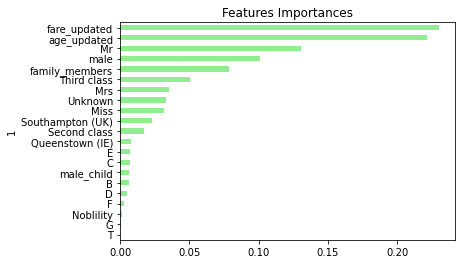

In [84]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

# Model 2
<h7> Optimising the model by increasing the number of trees in the forest

### Fitting the random forest model

In [85]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=1000, random_state=78)

In [86]:
# Fitting the model
rf_model = rf_model.fit(X_train, y_train)

In [87]:
# Make predictions
predictions = rf_model.predict(X_test)

### Evaluate the models performance

In [88]:
# Confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=['Actual - Did not survive', 'Actual - Survived'], columns=['Predicted - perished', 'Predicted - survived']
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [89]:
# Displaying results
print(f"The balanced accuracy score of the model is {balanced_accuracy_score(y_test, predictions)}")
print(f"The accuracy score of the model is : {acc_score}")
print(f"")
print("Confusion Matrix")
display(cm_df)
print("Classification Report")
print(classification_report(y_test, predictions))

The balanced accuracy score of the model is 0.7873497536945813
The accuracy score of the model is : 0.8109756097560976

Confusion Matrix


,Predicted - perished,Predicted - survived
Actual - Did not survive,180,23
Actual - Survived,39,86


Classification Report
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       203
           1       0.79      0.69      0.74       125

    accuracy                           0.81       328
   macro avg       0.81      0.79      0.79       328
weighted avg       0.81      0.81      0.81       328



### Feature importance

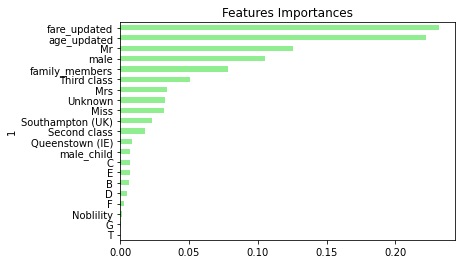

In [90]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

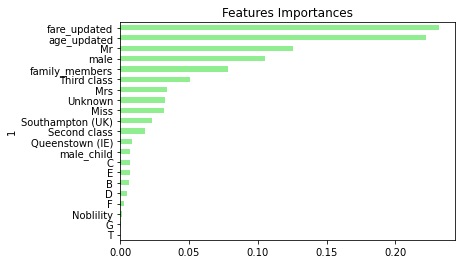

In [91]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

# Model 3 
<h7> Optomisation includes increasing the number of trees in the forest

### Fitting the random forest model

In [92]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=3000, random_state=78)

In [93]:
# Fitting the model
rf_model = rf_model.fit(X_train, y_train)

In [94]:
# Make predictions
predictions = rf_model.predict(X_test)

### Evaluate the models performance

In [95]:
# Confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=['Actual - Did not survive', 'Actual - Survived'], columns=['Predicted - perished', 'Predicted - survived']
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [96]:
# Displaying results
print(f"The balanced accuracy score of the model is {balanced_accuracy_score(y_test, predictions)}")
print(f"The accuracy score of the model is : {acc_score}")
print(f"")
print("Confusion Matrix")
display(cm_df)
print("Classification Report")
print(classification_report(y_test, predictions))

The balanced accuracy score of the model is 0.7848866995073891
The accuracy score of the model is : 0.8079268292682927

Confusion Matrix


,Predicted - perished,Predicted - survived
Actual - Did not survive,179,24
Actual - Survived,39,86


Classification Report
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       203
           1       0.78      0.69      0.73       125

    accuracy                           0.81       328
   macro avg       0.80      0.78      0.79       328
weighted avg       0.81      0.81      0.81       328



### Feature importance

In [97]:
# Assigning feature imprtorance to a value
importances = rf_model.feature_importances_
# Sort features by their importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.2312207483370338, 'fare_updated'),
 (0.22202026906357863, 'age_updated'),
 (0.1269806485965206, 'Mr'),
 (0.10505001954510018, 'male'),
 (0.07762830995933487, 'family_members'),
 (0.05162462455158283, 'Third class'),
 (0.03480524850182639, 'Mrs'),
 (0.032272548945475904, 'Unknown'),
 (0.031087061142798945, 'Miss'),
 (0.02294054492836904, 'Southampton (UK)'),
 (0.017343640337369688, 'Second class'),
 (0.008201707811481886, 'Queenstown (IE)'),
 (0.007687332237052479, 'male_child'),
 (0.007554366767088295, 'C'),
 (0.007313141842549014, 'E'),
 (0.006530423829340496, 'B'),
 (0.0051749850031639925, 'D'),
 (0.0026296359207904885, 'F'),
 (0.0011385848757856998, 'Noblility'),
 (0.0007961578037568161, 'G'),
 (0.0, 'T')]

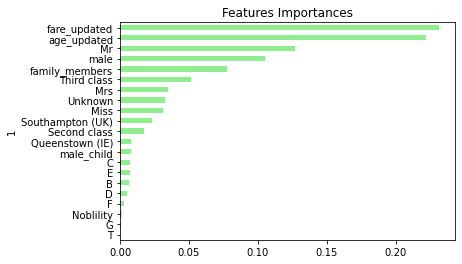

In [98]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)